# Happiness and Freedom

**A brief review of the World Happiness Report and Human Freedom Index in terms of how presence of freedom affects happiness.**.  
Analysis derived from data using the most recent World Happiness Report ([link](http://worldhappiness.report/)) and Human Freedom Index ([link](https://www.cato.org/human-freedom-index-new)).

"The secret to happiness is freedom... and the secret to freedom is courage." - Thucydides ([wikipedia](https://en.wikipedia.org/wiki/Thucydides))

It seems obvious that freedom leads to happiness but how much and how do different kinds of freedoms contribute to the overall picture?  We'll take a look at each category of freedom's relationship with reported happiness and it's own categories.  The aim is to create an overview of the two datasets, their relationship, and find strongly correlated categories from the two datasets.

##### General

* Freedom is positively correlated with happiness.  (A gut check)
* How do the two main categories of freedom, personal and economic, affect happiness and how does it differ in that effect?
* Examining the subcategories of personal freedom (top level).
* Examining the subcategories of economic freedom (top level).

#### Happiness in relation to individual freedom of movement

* How does freedom of movement affect happiness?  Individuals that can move freely should be more happy than those under more restrictions.
* How does gender affect freedom of movement?  Does gender play a role in in freedom of movement.  How does this affect happiness?

##### Happiness and relative geographic isolation

* How does geographic isolation relate to happiness?  Are people in landlocked countries less happy than those in coastal countries?
* How does geographic isolation relate to freedom of movement?  Are people in landlocked countries or coastal countries more free to move around?

#### Happiness Subcategories

* How is each category related to overall happiness and rank?
* How does each correlate to the strongest freedom category?


In [1]:
# imports
import sqlite3
import sqlalchemy as sa
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress
import sklearn.linear_model as sk

# create sqlite database and path
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Happiness_Freedom.db')

# set seaborn default theme
sns.set_palette("muted")

# multiple outputs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# create dataframes for each report from csv
hfi_file = pd.read_csv("hfi_cc_2018.csv")
hfi = pd.DataFrame(hfi_file)

whr_file = pd.read_csv("whr_2017.csv")
whr = pd.DataFrame(whr_file)

# create database and tables from dataframe
hfi.to_sql("Human Freedom Index", con=engine, if_exists="replace")
whr.to_sql("World Happiness Report", con=engine, if_exists="replace")

### Happiness is directly correlated with freedom

Let's start with a quick sanity check and make sure the happiness and freedom have a strong positive relationship.

Text(0.5,1,'Correlation of Happiness and Freedom')

LinregressResult(slope=0.6867913461953111, intercept=0.6236133610477834, rvalue=0.6330361581269445, pvalue=1.7569182578216024e-16, stderr=0.07282491965464152)

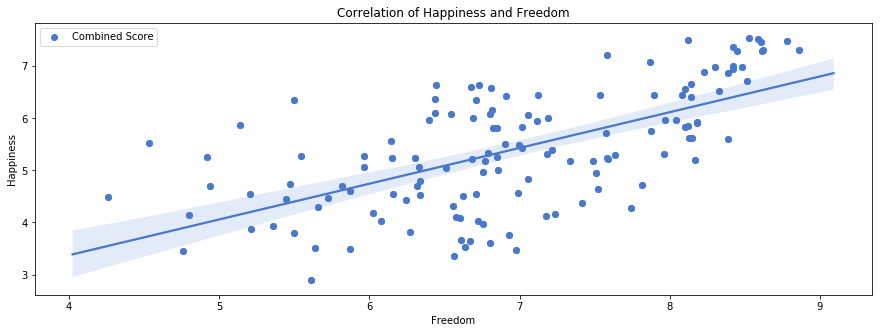

In [3]:
# get overall freedom score by country from Human Freedom Index
hf_score_by_country_data = "SELECT countries AS Country, hf_score AS Freedom FROM 'Human Freedom Index'"
hf_score_by_country = pd.read_sql(hf_score_by_country_data, con=engine)

# get overall happiness score by country from World Happiness Report
whr_data = "SELECT Country, [Happiness.Score] AS 'Happiness' FROM 'World Happiness Report' GROUP BY Country ORDER BY 'Happiness' DESC"
whr_raw = pd.read_sql(whr_data, con=engine)
whr = whr_raw.dropna()

# combine the two dataframes and group by country
reports_combined = pd.concat([hf_score_by_country, whr], sort=False)
reports_grouped = reports_combined.groupby("Country")["Freedom", "Happiness"].mean()
hf_wh_scores = reports_grouped.dropna()
hf_wh_scores.columns = ["Freedom", "Happiness"]
hf_wh_scores.index.name = "Country"

# Scatter/regression plot of happiness vs freedom
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x="Freedom", y="Happiness", data=hf_wh_scores)
points = plt.scatter(hf_wh_scores["Freedom"], hf_wh_scores["Happiness"], label="Combined Score")
ax.set_title("Correlation of Happiness and Freedom")
ax.legend();

x = hf_wh_scores["Freedom"]
y = hf_wh_scores["Happiness"]
linregress(x,y)

As expected, reported happiness and freedom have a moderate positive correlation in a linear fashion.

Slope = 0.69  
Correlation Coefficient = 0.63

### How the top and bottom 10 countries compare in happiness to freedom

Let's look at how the top 10 and bottom 10 countries compare in level of happiness.

So that we can consider both the overall happiness and freedom scores for each country, we will create a Happiness/Freedom Index by averaging the 2 scores for each country.

Text(0.5,1,'Top 10 HFI Countries')

[Text(0,0,'Norway'),
 Text(0,0,'Denmark'),
 Text(0,0,'Iceland'),
 Text(0,0,'Switzerland'),
 Text(0,0,'Finland'),
 Text(0,0,'Netherlands'),
 Text(0,0,'Canada'),
 Text(0,0,'New Zealand'),
 Text(0,0,'Australia')]

Text(0,0.5,'HFI Score')

(0, 10)

Text(0.5,1,'Bottom 10 HFI Countries')

[Text(0,0,'Madagascar'),
 Text(0,0,'Haiti'),
 Text(0,0,'Liberia'),
 Text(0,0,'Guinea'),
 Text(0,0,'Togo'),
 Text(0,0,'Rwanda'),
 Text(0,0,'Syria'),
 Text(0,0,'Tanzania'),
 Text(0,0,'Burundi')]

Text(0,0.5,'HFI Score')

(0, 10)

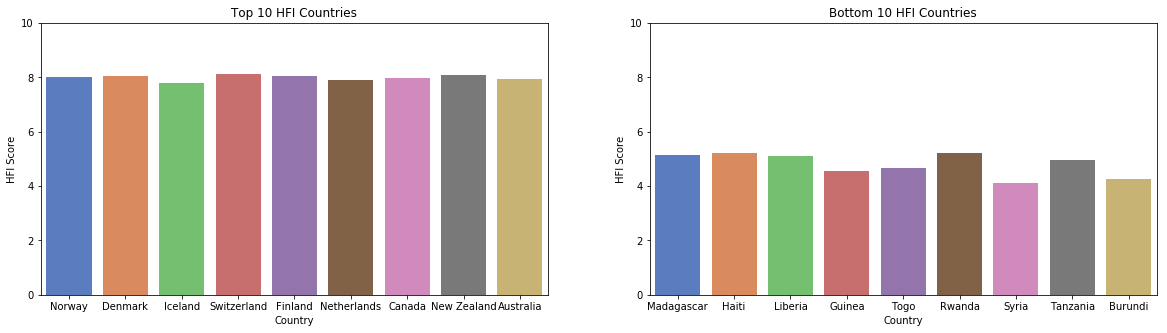

In [4]:
#  reset index adn sort by happiness score
hf_wh_scores_reset = hf_wh_scores.reset_index()
hf_wh_scores_by_country_raw = hf_wh_scores_reset.sort_values(by=['Happiness'], ascending=False)
hf_wh_scores_by_country_raw["Combined Score"] = hf_wh_scores_by_country_raw.mean(axis=1)

# get top 10 and bottom 10 rows and round score
hf_wh_scores_by_country_top = hf_wh_scores_by_country_raw[:9].round(2)
hf_wh_scores_by_country_bottom = hf_wh_scores_by_country_raw[-9:].round(2)

# plot bar graph for each category
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1 = sns.barplot(x="Country", y="Combined Score", data=hf_wh_scores_by_country_top, ax=ax1)
ax2 = sns.barplot(x="Country", y="Combined Score", data=hf_wh_scores_by_country_bottom, ax=ax2)
ax1.set_title("Top 10 HFI Countries")
ax1.set_xticklabels(hf_wh_scores_by_country_top["Country"])
ax1.set_ylabel("HFI Score")
ax1.set_ylim(0,10)
ax2.set_title("Bottom 10 HFI Countries")
ax2.set_xticklabels(hf_wh_scores_by_country_bottom["Country"])
ax2.set_ylabel("HFI Score")
ax2.set_ylim(0,10)

The top 10 countries combined scores are grouped tightly together hovering around 8 out of 10.

The bottom 10 countries combined scores show a little more variability ranging between 4 and 6 out of 10.

### Happiness, Personal, and Economic Freedom

How does personal freedom affect happiness?

How does economic freedom affect happiness?

In [5]:
# get personal and economic freedom scores by country from World Freedom Report
pf_ef_score_by_country_data = "SELECT countries AS 'Country', pf_score AS 'Personal Freedom', ef_score AS 'Economic Freedom' FROM 'Human Freedom Index'"
pf_ef_score_by_country_raw = pd.read_sql(pf_ef_score_by_country_data, con=engine)

# coombine the two dataframes
reports_combined = pd.concat([pf_ef_score_by_country_raw, whr], sort=False)
reports_grouped = reports_combined.groupby("Country")["Personal Freedom", "Economic Freedom", "Happiness"].mean()
pf_ef_scores = reports_grouped.dropna()

Text(0.5,1,'Happiness and Personal Freedom')

Text(0.5,1,'Happiness and Economic Freedom')

LinregressResult(slope=0.4792994286254869, intercept=1.9771523039640249, rvalue=0.5904565197157343, pvalue=4.8011190014548e-14, stderr=0.05680729070605633)

LinregressResult(slope=0.7572594668852657, intercept=0.2776175122816644, rvalue=0.5769568558547652, pvalue=2.4067155502762765e-13, stderr=0.09295607741457271)

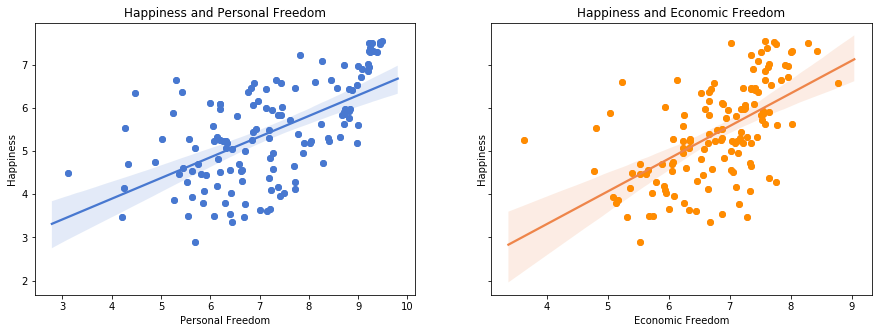

In [27]:
# regplot of happiness, personal freedom and economic freedom scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.regplot(x="Personal Freedom", y="Happiness", data=pf_ef_scores, ax=ax1)
sns.regplot(x="Economic Freedom", y="Happiness", data=pf_ef_scores, ax=ax2)
points1 = ax1.scatter(pf_ef_scores["Personal Freedom"], pf_ef_scores["Happiness"], label="Happiness and Personal Freedom")
points2 = ax2.scatter(pf_ef_scores["Economic Freedom"], pf_ef_scores["Happiness"], c="darkorange", label="Happiness and Economic Freedom") # color property necessary since default is used in first plot
ax1.set_title("Happiness and Personal Freedom")
ax2.set_title("Happiness and Economic Freedom")

x = pf_ef_scores["Personal Freedom"]
y = pf_ef_scores["Happiness"]
linregress(x,y)

x = pf_ef_scores["Economic Freedom"]
y = pf_ef_scores["Happiness"]
linregress(x,y)

__Personal Freedom:__  
Slope = 0.48  
Correlation Coefficient = 0.59  

__Economic Freedom__:  
Slope = 0.78  
Correlation Coefficient = 0.58  

Both categories show a moderate to strong positive linear relationship.  Economic freedom seems to be slightly more important than personal freedom though the overall range of each category is equal.  Economic freedoms include property rights, international trade regulations, and size of government.


### Personal Freedom Subcategories


Text(0.5,0.98,'Happiness and Personal Freedoms')

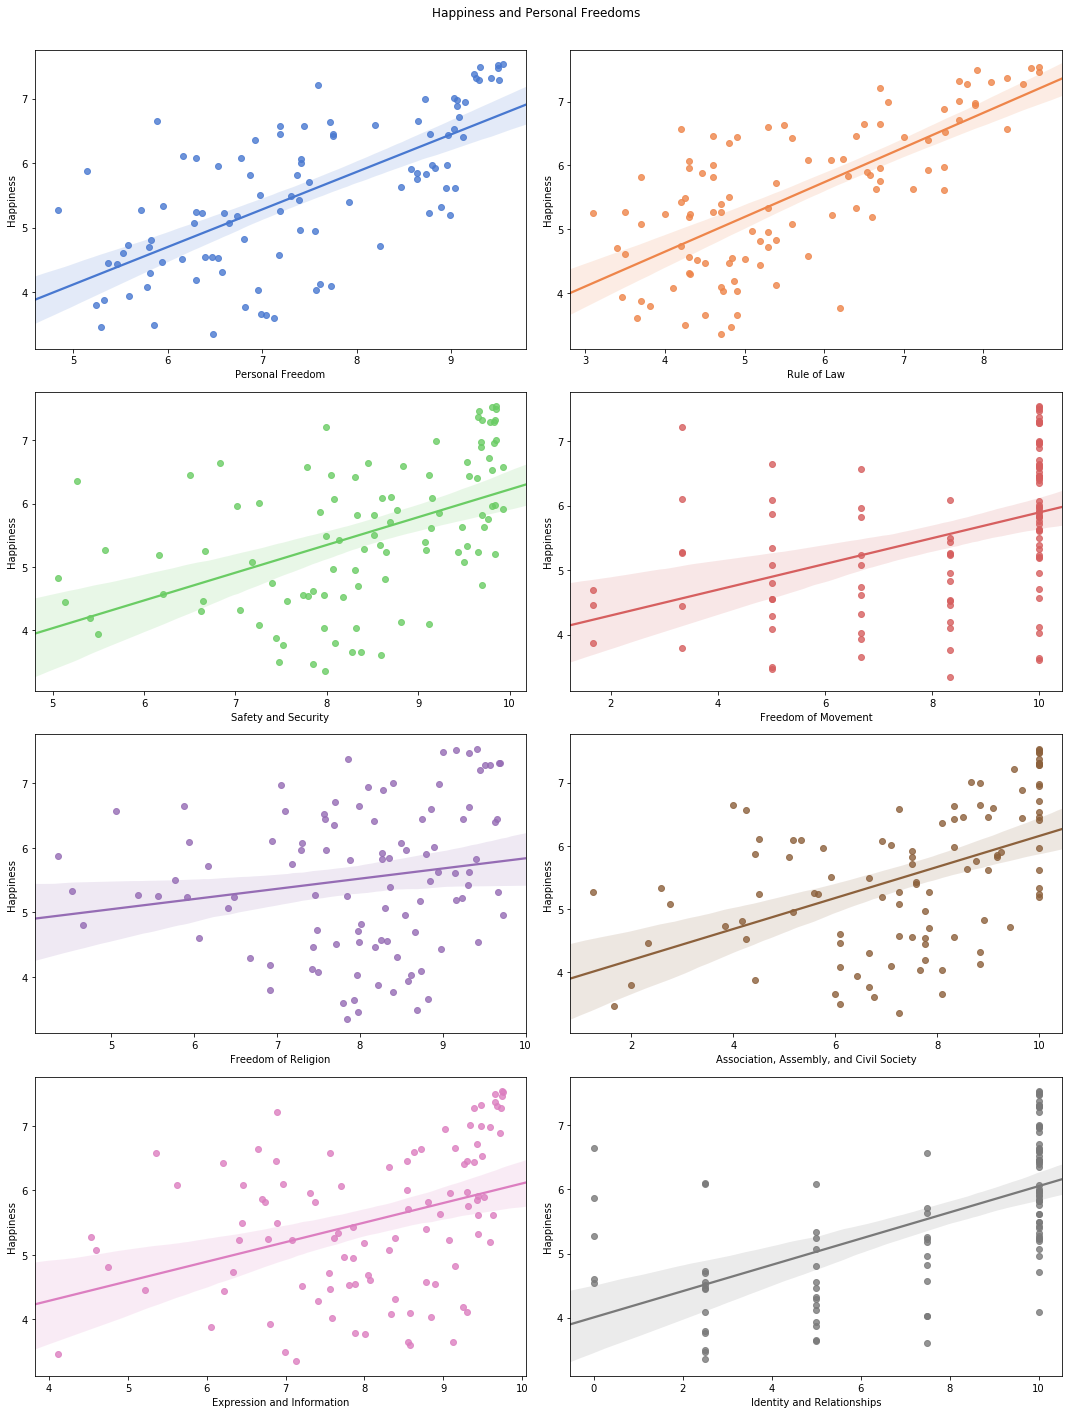

In [7]:
# Each personal freedom top level category
hfi_pf_top_raw = "SELECT countries AS Country, hf_score AS 'Freedom Score', pf_score AS 'Personal Freedom', pf_rol AS 'Rule of Law', pf_ss AS 'Safety and Security', pf_movement AS 'Freedom of Movement', pf_religion AS 'Freedom of Religion', pf_association AS 'Association, Assembly, and Civil Society', pf_expression AS 'Expression and Information', pf_identity AS 'Identity and Relationships' FROM 'Human Freedom Index' GROUP BY Country ORDER BY ef_score DESC"
hfi_pf_top_data = pd.read_sql(hfi_pf_top_raw, con=engine)
hfi_pf_top = hfi_pf_top_data.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_pf_top_whr_combined = pd.concat([hfi_pf_top, whr], sort=True)
hfi_pf_top_whr_grouped = hfi_pf_top_whr_combined.groupby("Country")["Happiness", "Freedom Score", "Personal Freedom", "Rule of Law", "Safety and Security", "Freedom of Movement", "Freedom of Religion", "Association, Assembly, and Civil Society", "Expression and Information", "Identity and Relationships"].mean()
hfi_pf_top_whr_cleaned = hfi_pf_top_whr_grouped.dropna()
hfi_pf_top_whr = hfi_pf_top_whr_cleaned.reset_index()

# plot of happiness and personal freedom subtypes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Personal Freedoms")
sns.regplot(x="Personal Freedom", y="Happiness", data=hfi_pf_top_whr, ax=axes[0,0])
sns.regplot(x="Rule of Law", y="Happiness", data=hfi_pf_top_whr, ax=axes[0,1])
sns.regplot(x="Safety and Security", y="Happiness", data=hfi_pf_top_whr, ax=axes[1,0])
sns.regplot(x="Freedom of Movement", y="Happiness", data=hfi_pf_top_whr, ax=axes[1,1])
sns.regplot(x="Freedom of Religion", y="Happiness", data=hfi_pf_top_whr, ax=axes[2,0])
sns.regplot(x="Association, Assembly, and Civil Society", y="Happiness", data=hfi_pf_top_whr, ax=axes[2,1])
sns.regplot(x="Expression and Information", y="Happiness", data=hfi_pf_top_whr, ax=axes[3,0])
sns.regplot(x="Identity and Relationships", y="Happiness", data=hfi_pf_top_whr, ax=axes[3,1])

plt.tight_layout()
fig.subplots_adjust(top=0.95)


In [8]:
# slope and correlation coefficient of happiness and personal freedom
print("Freedom")
x = hfi_pf_top_whr["Personal Freedom"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and rule of law
print("Rule of Law")
x = hfi_pf_top_whr["Rule of Law"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and safety and security
print("Safety & Security")
x = hfi_pf_top_whr["Safety and Security"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and movement
print("Freedom of Movement")
x = hfi_pf_top_whr["Freedom of Movement"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and religion
print("Freedom of Religion")
x = hfi_pf_top_whr["Freedom of Religion"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and association, assembly, and civil society
print("Assocaition, Assembly, & Civil Society")
x = hfi_pf_top_whr["Association, Assembly, and Civil Society"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and expression and information
print("Expression and Information")
x = hfi_pf_top_whr["Expression and Information"]
y = hfi_pf_top_whr["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and identity and relationships
print("Identity & Relationships")
x = hfi_pf_top_whr["Identity and Relationships"]
y = hfi_pf_top_whr["Happiness"]

linregress(x,y)

Freedom


LinregressResult(slope=0.5814124097219735, intercept=1.2128124812139918, rvalue=0.6796530299061834, pvalue=5.526542422314027e-15, stderr=0.06306661792937004)

Rule of Law


LinregressResult(slope=0.5450457875250867, intercept=2.463928756245908, rvalue=0.7125829208796739, pvalue=6.430467284276018e-17, stderr=0.053933930508916504)

Safety & Security


LinregressResult(slope=0.4391436470375125, intercept=1.8311487916803557, rvalue=0.4912612471714451, pvalue=1.8260003317276716e-07, stderr=0.07825296053662638)

Freedom of Movement


LinregressResult(slope=0.19963584697125336, intercept=3.8975658646616758, rvalue=0.4306623921212491, pvalue=6.943604677624239e-06, stderr=0.042047240372496734)

Freedom of Religion


LinregressResult(slope=0.15792119600215368, intercept=4.260769947245106, rvalue=0.17445284501361022, pvalue=0.08101748840914523, stderr=0.0895846302222597)

Assocaition, Assembly, & Civil Society


LinregressResult(slope=0.24592654121454077, intercept=3.696135379604434, rvalue=0.48531335162858075, pvalue=2.693848183939597e-07, stderr=0.044529319532895406)

Expression and Information


LinregressResult(slope=0.30322577109867405, intercept=3.0752598688061763, rvalue=0.36885038655365043, pvalue=0.00014734595413788782, stderr=0.07679667561733543)

Identity & Relationships


LinregressResult(slope=0.20475203226041092, intercept=4.004524509650698, rvalue=0.5923752560418506, pvalue=6.791227037048331e-11, stderr=0.027987666745681462)

#### Analysis:

**Strong relationship**: Rule of Law (0.71)

**Weak to moderate**: Saftey & Security (0.48), Movement (0.42), Association, Assembly, and Civil Society (0.38), Expression and Information (0.45), Identity and Relationships (0.46)

**None to weak** Relgion (0.16)

Rule of Law shows to highest correlation with happiness, while all other categories except Religion show a weak to moderate correlation to happiness. Rule of law includes personal protections, civil liberties, and freedom from "coerion by others".

### Economic Freedom Subcategories

Text(0.5,0.98,'Happiness and Economic Freedoms')

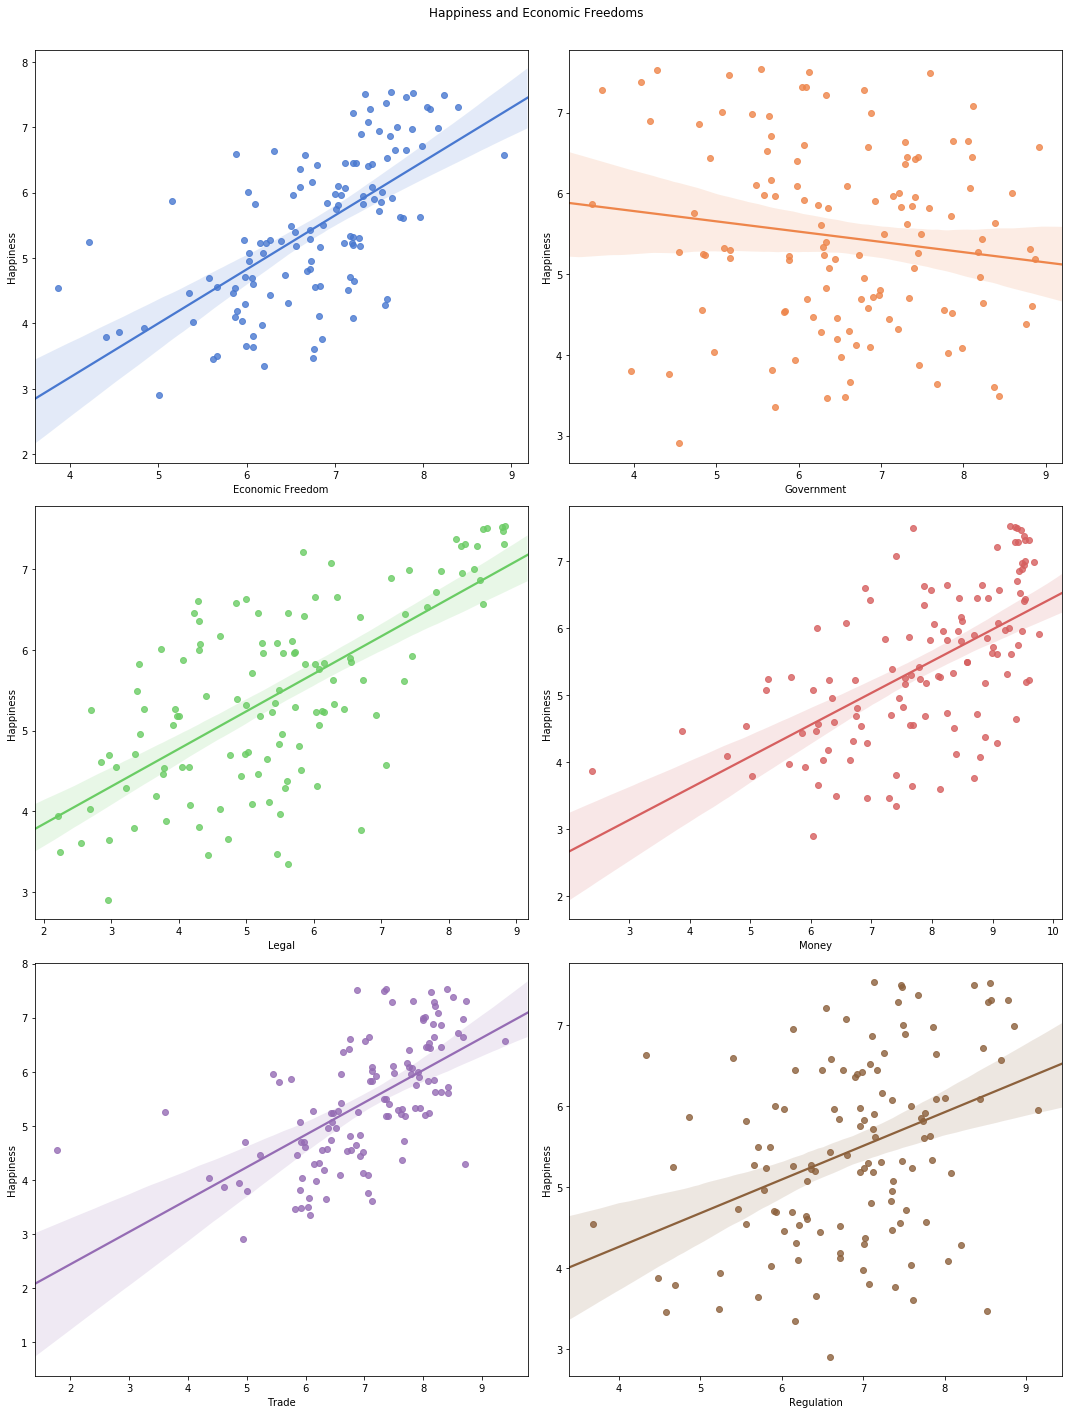

In [9]:
# Each economic freedom top level category
hfi_ef_top_raw = "SELECT countries AS Country, hf_score AS 'Freedom Score', ef_score AS 'Economic Freedom', ef_government AS 'Government', ef_legal AS 'Legal', ef_money AS 'Money', ef_trade AS 'Trade', ef_regulation AS 'Regulation' FROM 'Human Freedom Index' GROUP BY Country ORDER BY ef_score DESC"
hfi_ef_top_data = pd.read_sql(hfi_ef_top_raw, con=engine)
hfi_ef_top = hfi_ef_top_data.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_top_whr_combined = pd.concat([hfi_ef_top, whr], sort=True)
hfi_top_whr_grouped = hfi_top_whr_combined.groupby("Country")["Happiness", "Economic Freedom", "Government", "Legal", "Money", "Trade", "Regulation"].mean()
hfi_top_whr_cleaned = hfi_top_whr_grouped.dropna()
hfi_top_whr = hfi_top_whr_cleaned.reset_index()

# plot of happiness and personal freedom subtypes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Economic Freedoms")
sns.regplot(x="Economic Freedom", y="Happiness", data=hfi_top_whr, ax=axes[0,0])
sns.regplot(x="Government", y="Happiness", data=hfi_top_whr, ax=axes[0,1])
sns.regplot(x="Legal", y="Happiness", data=hfi_top_whr, ax=axes[1,0])
sns.regplot(x="Money", y="Happiness", data=hfi_top_whr, ax=axes[1,1])
sns.regplot(x="Trade", y="Happiness", data=hfi_top_whr, ax=axes[2,0])
sns.regplot(x="Regulation", y="Happiness", data=hfi_top_whr, ax=axes[2,1])

plt.tight_layout()
fig.subplots_adjust(top=0.95)


In [10]:
# slope and correlation coefficient of happiness and economic freedom
print("Economic Freedom")
x = hfi_top_whr["Economic Freedom"]
y = hfi_top_whr["Happiness"]
linregress(x,y)

print("Government")
x = hfi_top_whr["Government"]
y = hfi_top_whr["Happiness"]
linregress(x,y)

print("Legal")
x = hfi_top_whr["Legal"]
y = hfi_top_whr["Happiness"]
linregress(x,y)

print("Money")
x = hfi_top_whr["Money"]
y = hfi_top_whr["Happiness"]
linregress(x,y)

print("Trade")
x = hfi_top_whr["Trade"]
y = hfi_top_whr["Happiness"]
linregress(x,y)

print("Regulation")
x = hfi_top_whr["Regulation"]
y = hfi_top_whr["Happiness"]
linregress(x,y)

Economic Freedom


LinregressResult(slope=0.8252860165049533, intercept=-0.125369130354124, rvalue=0.6487565093381257, pvalue=4.899002001742474e-16, stderr=0.08800603945958749)

Government


LinregressResult(slope=-0.12716901696771032, intercept=6.288322154990945, rvalue=-0.13781580946982475, pvalue=0.12848374949408994, stderr=0.08308556895217893)

Legal


LinregressResult(slope=0.46519862682790597, intercept=2.9117443140562242, rvalue=0.6759798258082297, pvalue=9.626889464160156e-18, stderr=0.04610334356071345)

Money


LinregressResult(slope=0.47443422779802824, intercept=1.7149713180785349, rvalue=0.5958237481839898, pvalue=3.6012685190512524e-13, stderr=0.058135763031711134)

Trade


LinregressResult(slope=0.598681547411327, intercept=1.240002949355958, rvalue=0.6118864488088822, pvalue=5.5335784022332636e-14, stderr=0.07035240972763246)

Regulation


LinregressResult(slope=0.4163801998840268, intercept=2.5947683040072294, rvalue=0.3777212648901595, pvalue=1.6546453235592395e-05, stderr=0.09278955881872156)

#### Analysis:

**Strong relationship**: Legal (0.68)

**Weak to moderate**: Trade (0.62), Money (0.60), Regulation (0.38)

**None to weak** Government (0.14)

Legal (System and Property Rights) include judical enforcement, integrity, and independence.

Note: Government shows a negative slope as opposed to other categories.  This is due to a decrease in happiness as government size increases although the coorelation is weak.


## Happiness in relation to individual freedom of movement

### Happiness and Movement Freedom

* How is happiness affected by movement freedom?

Text(0.5,1,'Correlation of General Happiness and Movement Freedom')

LinregressResult(slope=0.19384737724068232, intercept=3.865210669228947, rvalue=0.40395224050215855, pvalue=3.948639184319359e-06, stderr=0.0400733806885717)

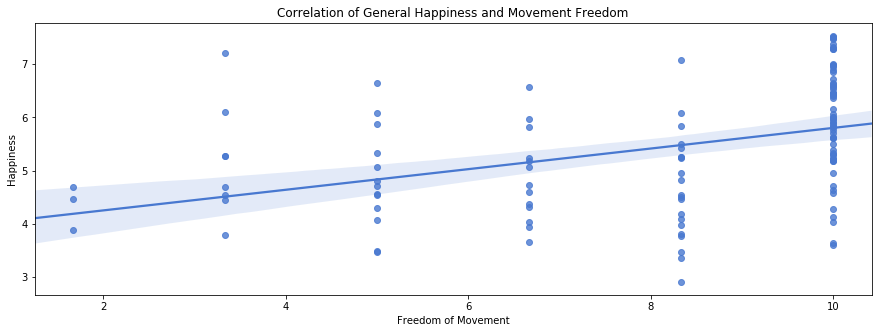

In [28]:
# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_movement_by_country_raw = "SELECT countries AS 'Country', pf_movement AS 'Freedom of Movement', pf_movement_domestic AS 'Domestic Movement', pf_movement_foreign AS 'Foreign Movement', pf_movement_women AS 'Womens Movement' FROM 'Human Freedom Index' GROUP BY countries ORDER BY pf_score DESC"
hfi_movement_by_country_data = pd.read_sql(hfi_movement_by_country_raw, con=engine)
hfi_movement_by_country = hfi_movement_by_country_data.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_movement_whr_happiness_by_country_combined = pd.concat([hfi_movement_by_country, whr], sort=True)
hfi_movement_whr_happiness_by_country_grouped = hfi_movement_whr_happiness_by_country_combined.groupby("Country")["Happiness", "Freedom of Movement", "Domestic Movement", "Foreign Movement", "Womens Movement"].mean()
hfi_movement_whr_happiness_by_country = hfi_movement_whr_happiness_by_country_grouped.dropna()

# scatter plot analysis with linear regression
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x="Freedom of Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=ax)
ax.set_title("Correlation of General Happiness and Movement Freedom")

x = hfi_movement_whr_happiness_by_country["Freedom of Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

Slope = 0.19   
Correlation Coefficient = 0.40

Movment freedom shows a moderate correlation but less than expected.

Let's now look at the subcategories of movement freedom: domestic, foreign, and women's.

### Happiness and types of movement  

* Subcategories: Domestic, foreign, and women's movement freedom

Text(0.5,0.98,'Happiness and Freedom of Movement')

LinregressResult(slope=0.19384737724068232, intercept=3.865210669228947, rvalue=0.40395224050215855, pvalue=3.948639184319359e-06, stderr=0.0400733806885717)

LinregressResult(slope=0.12524635510928528, intercept=4.486462509188343, rvalue=0.3986688491682361, pvalue=5.41240705840397e-06, stderr=0.026301255055421024)

LinregressResult(slope=0.09322213476133365, intercept=4.733206502033217, rvalue=0.2967332753905574, pvalue=0.0009038423009149428, stderr=0.02738719365529842)

LinregressResult(slope=0.11382046038111927, intercept=4.411231037694739, rvalue=0.18839487581167114, pvalue=0.0376988147725481, stderr=0.05416433358800328)

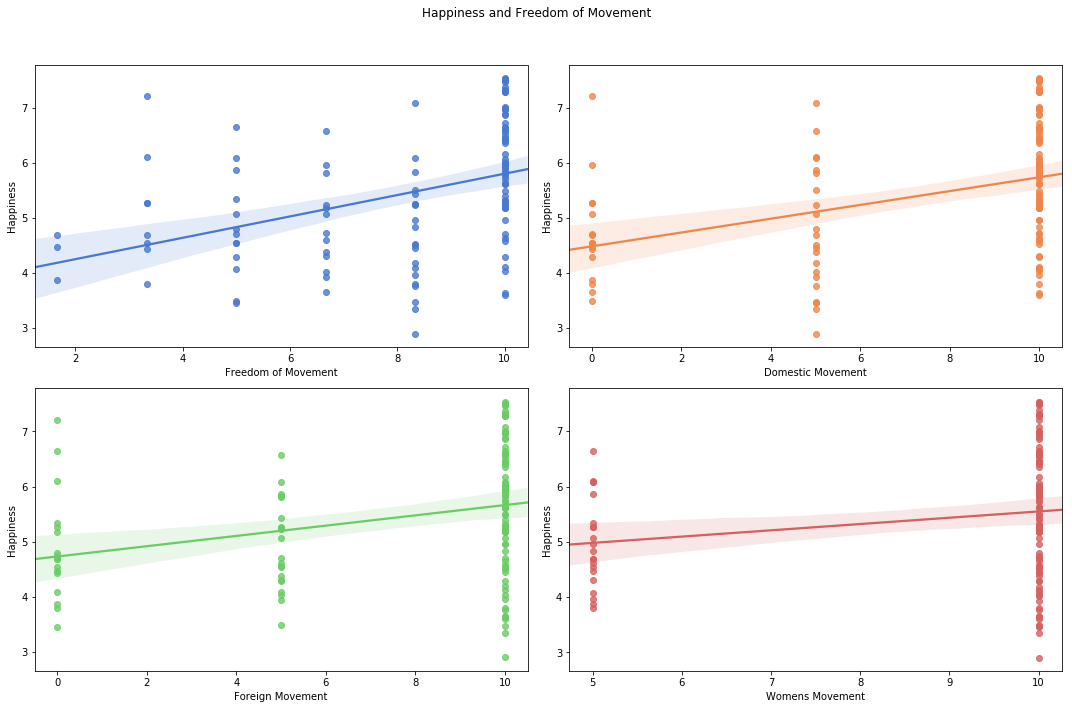

In [12]:
# Correlation of happiness and all movement freedom types

# plot of happiness freedom and personal freedom subtypes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Happiness and Freedom of Movement")
sns.regplot(x="Freedom of Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[0,0])
sns.regplot(x="Domestic Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[0,1])
sns.regplot(x="Foreign Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[1,0])
sns.regplot(x="Womens Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[1,1])

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = hfi_movement_whr_happiness_by_country["Freedom of Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["Domestic Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["Foreign Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["Womens Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

#### Analysis:

**Weak to moderate**:  Domestic Travel (0.40), Foreign Travel (0.30), Women's Movement (0.19) 

Domestic travel has the strongest correlation with happiness which seems to be a benefit for isolated countries.

### Happiness, Movement Freedom, and Gender

How is happiness affected by the movement freedom of each gender?

We average each gender's movement freedom for all countries and compare to each other.

Text(0.5,1,'Freedom and Movement Freedom by Gender')

Text(0,0.5,'Freedom')

(5, 10)

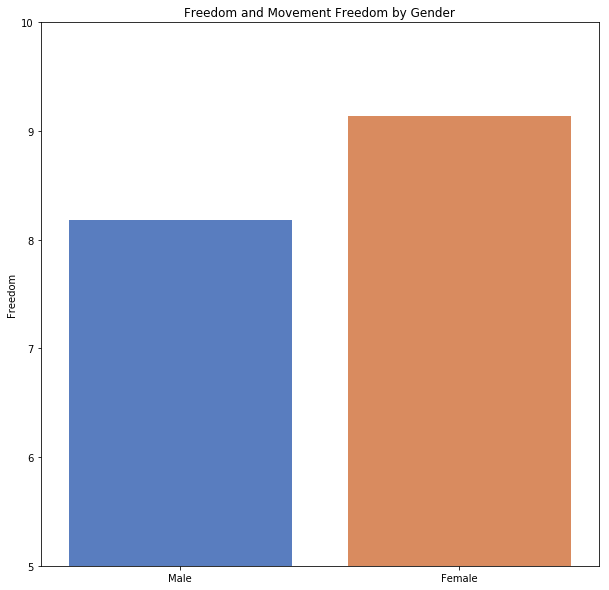

In [32]:
# Comparison of general movement freedom and women's movement freedom
hfi_movement_gender_whr_raw = hfi_movement_whr_happiness_by_country.groupby("Country")["Happiness", "Freedom of Movement", "Womens Movement"].mean()
hfi_movement_gender_whr_dropped = hfi_movement_gender_whr_raw.dropna()
hfi_movement_gender_whr_grouped = hfi_movement_gender_whr_dropped.reset_index().drop(columns=["Country"])
hfi_movement_gender_whr_grouped.columns = ["Happiness", "Male", "Female"]

# avg movment freedom for each gender
male_mean = hfi_movement_gender_whr_grouped["Male"].mean()
female_mean = hfi_movement_gender_whr_grouped["Female"].mean()

# combine average scores into data array and label
combined_gender_mean = pd.DataFrame([male_mean, female_mean]).T 
combined_gender_mean.columns = ["Male", "Female"]
combined_gender_mean.index = ["Freedom"]

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(data=combined_gender_mean);
ax.set_title("Freedom and Movement Freedom by Gender")
ax.set_ylabel("Freedom")
ax.set_ylim(5, 10)

Countries with higher freedom of movement for women average higher happiness scores.

## Happiness and geographic isolation  
* How is happiness affected by the geography of the country? (Coastal versus Landlocked)

In [14]:
# get list of landlocked countries
landlocked_countries = pd.Series(["Afghanistan", "Andorra", "Armenia", "Artsakh", "Austria", "Azerbaijan", "Belarus", "Bhutan", "Bolivia", "Botswana", "Burkina Faso", "Burundi", "Central African Republic", "Chad", "Czech Republic", "Ethiopia", "Hungary","Kazakhstan", "Kosovo", "Kyrgyzstan", "Laos", "Lesotho", "Liechtenstein", "Luxembourg", "Macedonia", "Malawi", "Mali", "Moldova", "Mongolia", "Nepal", "Niger", "Paraguay", "Rwanda", "San Marino" , "Serbia", "Slovakia", "South Ossetia", "South Sudan", "Swaziland", "Switzerland","Tajikistan", "Transnistria", "Turkmenistan", "Uganda", "Uzbekistan","Vatican City", "West Bank", "Zambia", "Zimbabwe"])


Text(0.5,1,'Happiness range in countries based on geography')

(0, 10)

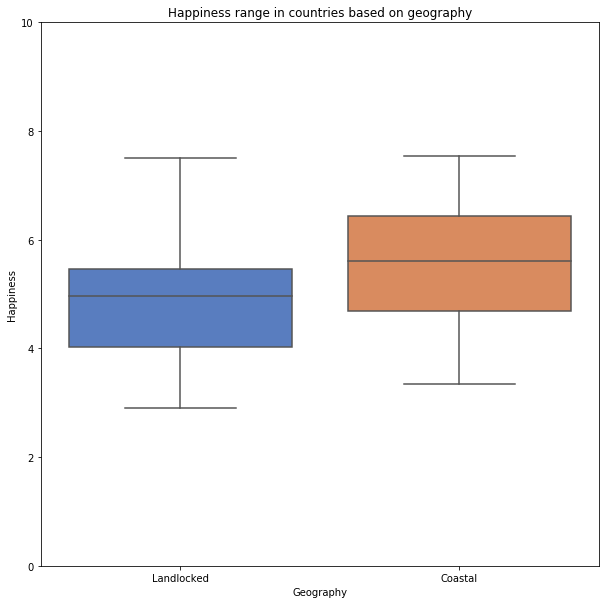

In [15]:
# create list of land-locked countries and coastal countries
landlocked_happiness = hf_wh_scores_by_country_raw.loc[hf_wh_scores_by_country_raw["Country"].isin(landlocked_countries)]
coastal_happiness = hf_wh_scores_by_country_raw.loc[~hf_wh_scores_by_country_raw["Country"].isin(landlocked_countries)]

# combine dataframes
combined_happiness_raw = pd.concat([landlocked_happiness, coastal_happiness])
combined_happiness = combined_happiness_raw.drop(columns=["Combined Score"])

# mark countries as landlocked or coastal
combined_happiness["Geography"] = ""
combined_happiness["Geography"] = np.where(combined_happiness["Country"].isin(landlocked_countries), "Landlocked", "Coastal")
combined_happiness = combined_happiness.sort_values(by="Happiness").drop(columns=["Country"])

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="Geography", y="Happiness", data=combined_happiness)
ax.set_title("Happiness range in countries based on geography")
ax.set_ylim(0, 10)

Text(0.5,1,'Happiness in Landlocked vs Coastal Countries')

(0, 10)

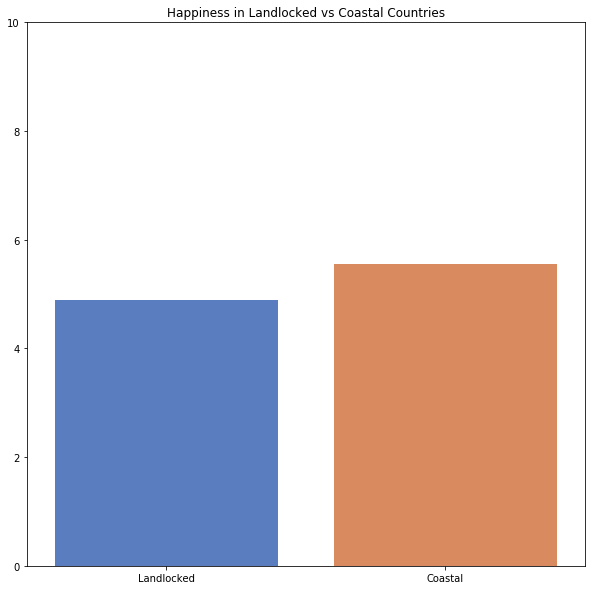

In [16]:
# avg happiness in landlocked vs coastal countries
landlocked_happiness_mean = landlocked_happiness["Happiness"].mean()
coastal_happiness_mean = coastal_happiness["Happiness"].mean()

# combine into data array and traverse rows to columns (single happiness row, typed columns)
combined_happiness_mean = pd.DataFrame([landlocked_happiness_mean, coastal_happiness_mean]).T 

combined_happiness_mean.columns = ["Landlocked", "Coastal"]
combined_happiness_mean.index = ["Happiness"]

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(data=combined_happiness_mean);
ax.set_title("Happiness in Landlocked vs Coastal Countries")
ax.set_ylim(0, 10)

Happiness in coastal countries seems to average higher than landlocked countries although there is a lot of overlap.

Text(0.5,1,'Correlation of Happiness and Freedom in Landlocked vs Coastal')

LinregressResult(slope=0.8786316163050915, intercept=-1.0922589058503362, rvalue=0.7158647604073939, pvalue=8.687374465791945e-06, stderr=0.16195744036889148)

LinregressResult(slope=0.6303437707662627, intercept=1.1371292209288013, rvalue=0.6179284067523297, pvalue=2.1823642234112312e-12, stderr=0.0790264944123492)

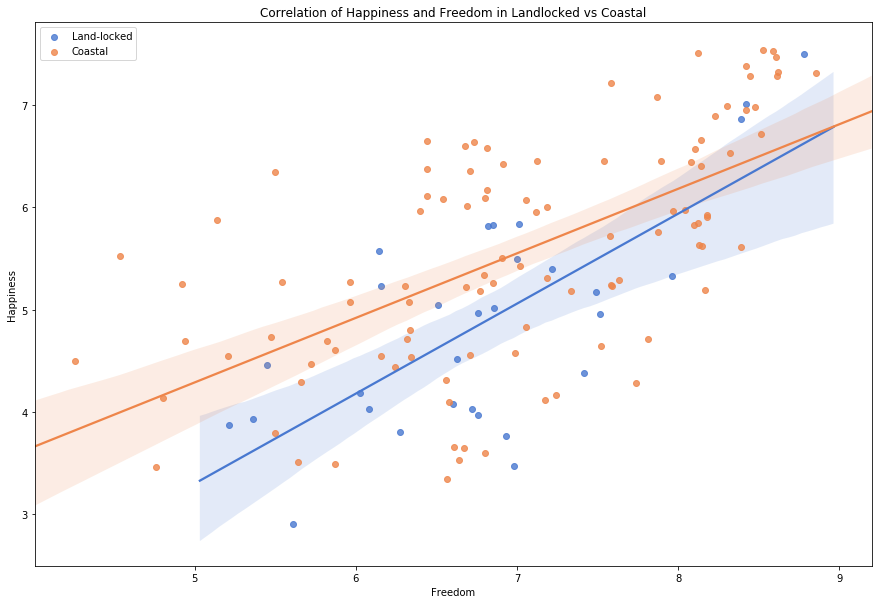

In [17]:
# Regplots of happiness and freedom for landlocked vs coastal countries
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="Freedom", y="Happiness", data=landlocked_happiness, label="Land-locked")
sns.regplot(x="Freedom", y="Happiness", data=coastal_happiness, label="Coastal")
ax.set_title("Correlation of Happiness and Freedom in Landlocked vs Coastal")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_happiness["Freedom"]
y = landlocked_happiness["Happiness"]
linregress(x,y)

x = coastal_happiness["Freedom"]
y = coastal_happiness["Happiness"]
linregress(x,y)

### Happiness and movement freedom in land-locked versus coastal countries

Text(0.5,1,'Correlation of Happiness and Freedom of Movement in Landlocked vs non-Landlocked countries')

Text(0.5,0,'Freedom of Movement')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.2634076329039947, intercept=2.6653812897946585, rvalue=0.4509848188048423, pvalue=0.018226123164837238, stderr=0.10426055671413943)

LinregressResult(slope=0.18566767450354887, intercept=4.109416343979116, rvalue=0.42531559049079953, pvalue=1.7355633151802674e-05, stderr=0.0409688474579896)

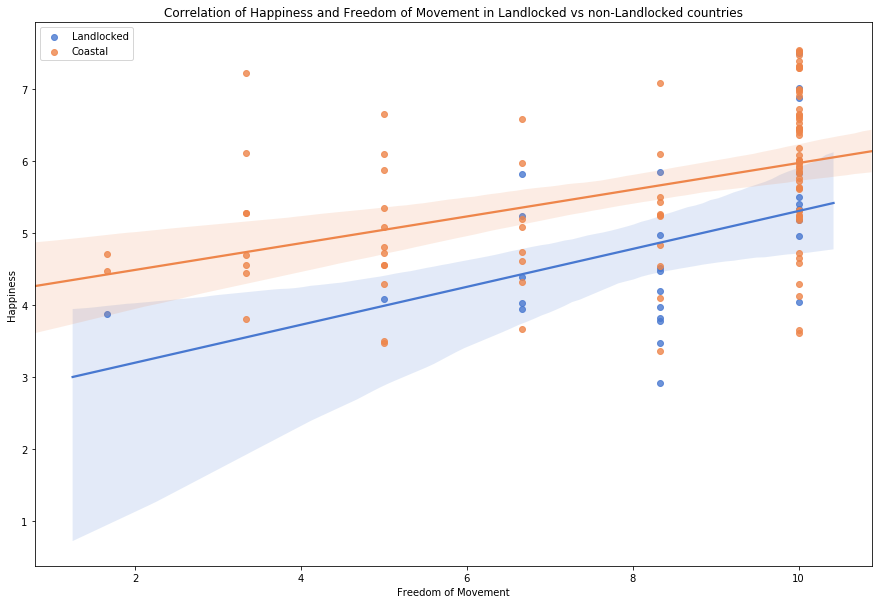

In [18]:
# reset index of dataframe from country list to index
hfi_movement_whr_happiness_by_country_reset = hfi_movement_whr_happiness_by_country.reset_index()
hfi_movement_whr_happiness_by_country_reset.rename(columns={'countries':'Country'}, inplace=True)

# create list of land-locked countries and coastal countries
landlocked_movement_happiness = hfi_movement_whr_happiness_by_country_reset.loc[hfi_movement_whr_happiness_by_country_reset["Country"].isin(landlocked_countries)]
coastal_movement_happiness = hfi_movement_whr_happiness_by_country_reset.loc[~hfi_movement_whr_happiness_by_country_reset["Country"].isin(landlocked_countries)]

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="Freedom of Movement", y="Happiness", data=landlocked_movement_happiness, label="Landlocked")
sns.regplot(x="Freedom of Movement", y="Happiness", data=coastal_movement_happiness, label="Coastal")
ax.set_title("Correlation of Happiness and Freedom of Movement in Landlocked vs non-Landlocked countries")
ax.set_xlabel("Freedom of Movement")
ax.set_ylabel("Happiness")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_movement_happiness["Freedom of Movement"]
y = landlocked_movement_happiness["Happiness"]
linregress(x,y)

x = coastal_movement_happiness["Freedom of Movement"]
y = coastal_movement_happiness["Happiness"]
linregress(x,y)


**Land-locked:**
Correllation Coefficient: 0.45  
**Coastal**
Correllation Coefficient: 0.43

Text(0.5,1,'Happiness and Rule of Law in Landlocked vs non-Landlocked countries')

LinregressResult(slope=0.3156766270845451, intercept=3.2925441143025735, rvalue=0.3510414772345616, pvalue=0.16710165074245756, stderr=0.21741083093110536)

LinregressResult(slope=0.46065690745502824, intercept=3.083587430161188, rvalue=0.6753375912198023, pvalue=1.4309335017899922e-10, stderr=0.06100555419977643)

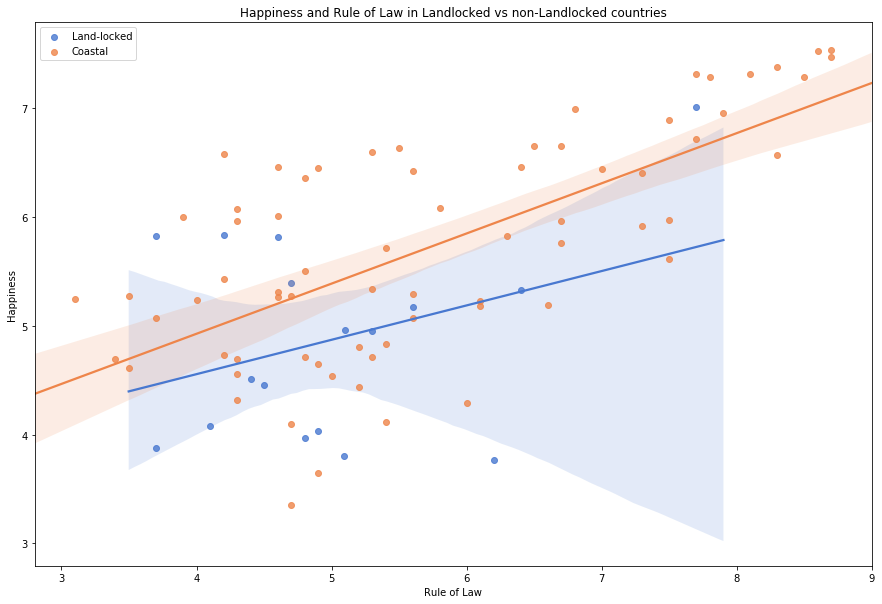

In [19]:
# combine Rule of Law from HFI with Happiness 

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_rol_data = "SELECT countries AS Country, pf_rol AS 'Rule of Law', pf_rol_procedural AS 'Procedural', pf_rol_civil AS 'Civility', pf_rol_criminal AS 'Criminality' FROM 'Human Freedom Index' GROUP BY Country ORDER BY pf_score DESC"
hfi_rol_raw = pd.read_sql(hfi_rol_data, con=engine)
hfi_rol_by_country = hfi_rol_raw.dropna()

# coombine the two dataframes grouping by county and dropping null values
whr.columns = ["Country", "Happiness"]
hfi_rol_whr_happiness_by_country_combined = pd.concat([hfi_rol_by_country, whr], sort=True)
hfi_rol_whr_happiness_by_country_grouped = hfi_rol_whr_happiness_by_country_combined.groupby("Country")["Happiness", "Rule of Law", "Procedural", "Civility", "Criminality"].mean()
hfi_rol_whr_happiness_by_country_cleaned = hfi_rol_whr_happiness_by_country_grouped.dropna()
hfi_rol_whr_happiness_by_country = hfi_rol_whr_happiness_by_country_cleaned.reset_index()

# list non land locked countries

landlocked_rol_happiness = hfi_rol_whr_happiness_by_country.loc[hfi_rol_whr_happiness_by_country["Country"].isin(landlocked_countries)]
coastal_rol_happiness = hfi_rol_whr_happiness_by_country.loc[~hfi_rol_whr_happiness_by_country["Country"].isin(landlocked_countries)]

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="Rule of Law", y="Happiness", data=landlocked_rol_happiness, label="Land-locked")
sns.regplot(x="Rule of Law", y="Happiness", data=coastal_rol_happiness, label="Coastal")
ax.set_title("Happiness and Rule of Law in Landlocked vs non-Landlocked countries")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_rol_happiness["Rule of Law"]
y = landlocked_rol_happiness["Happiness"]
linregress(x,y)

x = coastal_rol_happiness["Rule of Law"]
y = coastal_rol_happiness["Happiness"]
linregress(x,y)

#### Happiness Subcategories

* How is each category related to overall happiness and rank?
* How does each correlate to the strongest freedom category, Rule of Law?

In [20]:
whr_subcategories_data = "SELECT Country, [Happiness.Score] AS 'Happiness', [Economy..GDP.per.Capita.] AS 'Economy (GDP)', Family, [Health..Life.Expectancy.] AS 'Health & Life Expectancy', Freedom, Generosity, [Trust..Government.Corruption.] AS 'Trust Government/Corruption', [Dystopia.Residual] AS 'Dystopia Residual' FROM 'World Happiness Report' GROUP BY Country"
whr_subcategories_raw = pd.read_sql(whr_subcategories_data, con=engine)
whr_subcategories = whr_subcategories_raw.dropna()

Text(0.5,0.98,'Happiness and Categories of Happiness')

Text(0,0.5,'Happiness')

Text(0.5,0,'Economy (GDP)')

Text(0,0.5,'Happiness')

Text(0.5,0,'Family')

Text(0,0.5,'Happiness')

Text(0.5,0,'Health & Life Expectancy')

Text(0,0.5,'Happiness')

Text(0.5,0,'Freedom')

Text(0,0.5,'Happiness')

Text(0.5,0,'Generosity')

Text(0.5,0,'Trust Government/Corruption')

Text(0,0.5,'Happiness')

Text(0.5,0,'Dystopia Residual')

Text(0,0.5,'Happiness')

(0.03676434140336969, 1.9365936848606855, 5.059548291206361, 5.648490420341491)

LinregressResult(slope=2.1841849463496823, intercept=3.2032126826861878, rvalue=0.812468753886642, pvalue=1.1103905896573228e-37, stderr=0.1267094804726199)

LinregressResult(slope=2.96424751523216, intercept=1.8298321531238804, rvalue=0.7527366726961481, pvalue=1.4163391139614235e-29, stderr=0.20958677033185413)

LinregressResult(slope=3.731201709128992, intercept=3.2968556853783144, rvalue=0.7819506247990082, pvalue=3.2129704689696394e-33, stderr=0.24046337464539952)

LinregressResult(slope=4.2997863418550235, intercept=3.5963270129355083, rvalue=0.5701371935975075, pvalue=9.68789889785894e-15, stderr=0.5009051793321111)

LinregressResult(slope=1.3030836194209647, intercept=5.032309548004588, rvalue=0.1552558391127447, pvalue=0.053732504079261965, stderr=0.6703171217895821)

LinregressResult(slope=4.774591796345779, intercept=4.766170560287328, rvalue=0.42907973722217196, pvalue=2.538310699741571e-08, stderr=0.8125844091082511)

LinregressResult(slope=1.0754110388489102, intercept=3.364253195122525, rvalue=0.4753551243132996, pvalue=4.102379868569846e-10, stderr=0.16091317244367698)

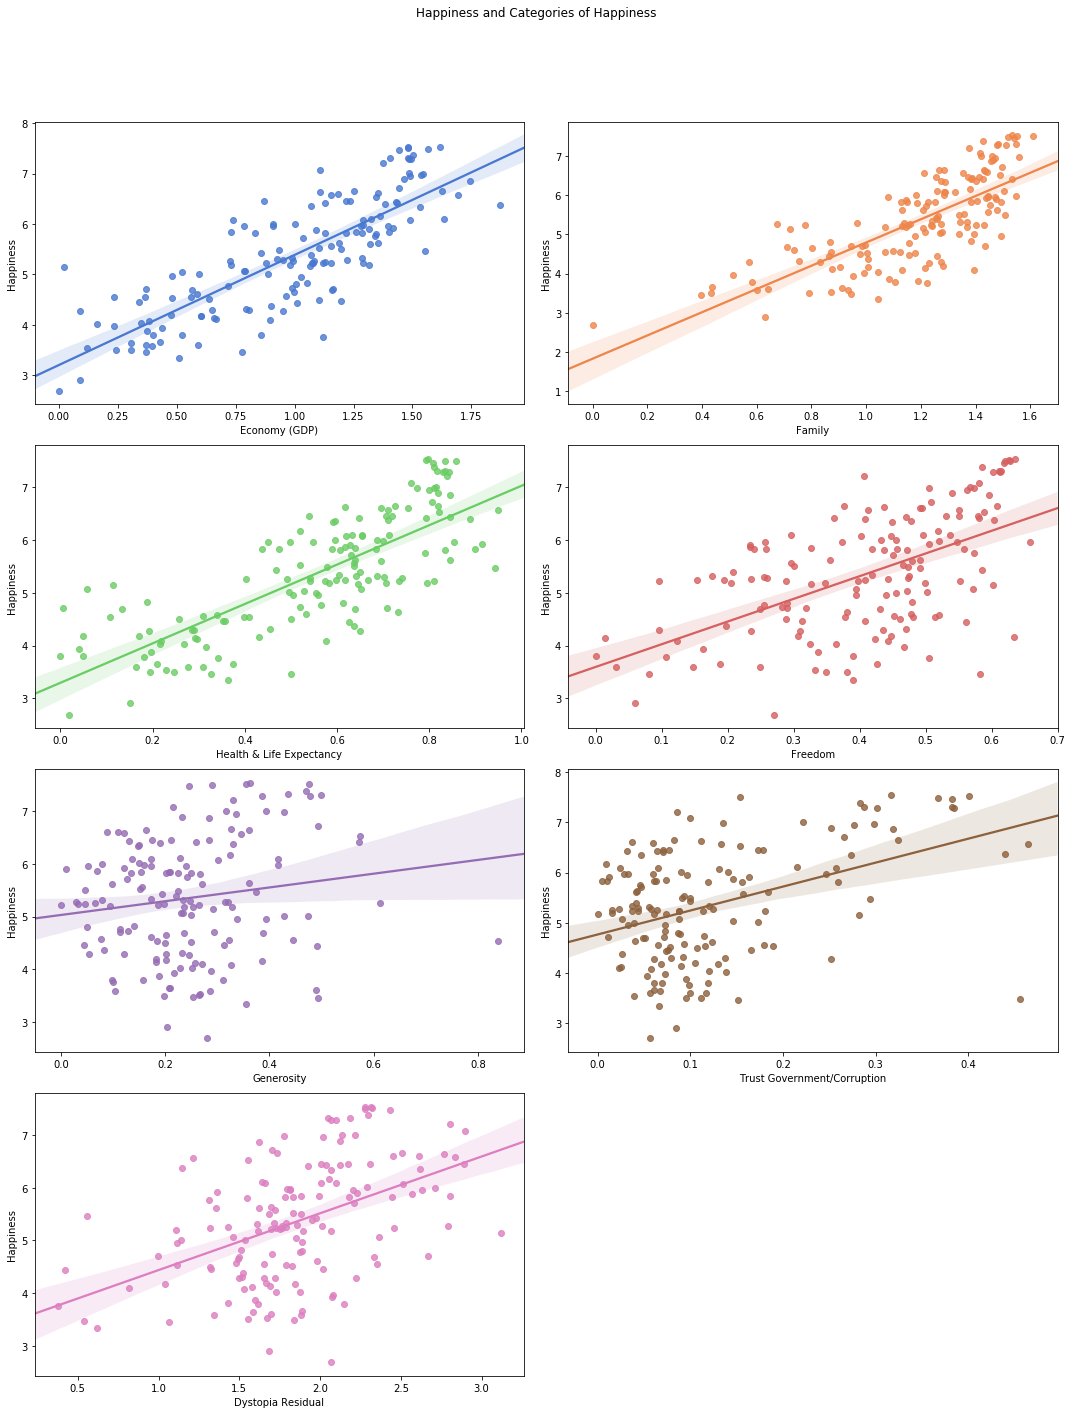

In [21]:
# plot of happiness and subtypes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Categories of Happiness")

sns.regplot(x="Economy (GDP)", y="Happiness", data=whr_subcategories, ax=axes[0,0])
sns.regplot(x="Family", y="Happiness", data=whr_subcategories, ax=axes[0,1])

axes[0,0].set_ylabel("Happiness")
axes[0,0].set_xlabel("Economy (GDP)")
axes[0,1].set_ylabel("Happiness")
axes[0,1].set_xlabel("Family")

sns.regplot(x="Health & Life Expectancy", y="Happiness", data=whr_subcategories, ax=axes[1,0])
sns.regplot(x="Freedom", y="Happiness", data=whr_subcategories, ax=axes[1,1])

axes[1,0].set_ylabel("Happiness")
axes[1,0].set_xlabel("Health & Life Expectancy")
axes[1,1].set_ylabel("Happiness")
axes[1,1].set_xlabel("Freedom")

sns.regplot(x="Generosity", y="Happiness", data=whr_subcategories, ax=axes[2,0])
sns.regplot(x="Trust Government/Corruption", y="Happiness", data=whr_subcategories, ax=axes[2,1])

axes[2,0].set_ylabel("Happiness")
axes[2,0].set_xlabel("Generosity")
axes[2,1].set_xlabel("Trust Government/Corruption")
axes[2,1].set_ylabel("Happiness")

sns.regplot(x="Dystopia Residual", y="Happiness", data=whr_subcategories, ax=axes[3,0])

axes[3,0].set_xlabel("Dystopia Residual")
axes[3,0].set_ylabel("Happiness")
axes[3,1].axis("off") 

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = whr_subcategories["Economy (GDP)"]
y = whr_subcategories["Happiness"]
linregress(x,y)

x = whr_subcategories["Family"]
y = whr_subcategories["Happiness"]
linregress(x,y)

x = whr_subcategories["Health & Life Expectancy"]
y = whr_subcategories["Happiness"]
linregress(x,y)

x = whr_subcategories["Freedom"]
y = whr_subcategories["Happiness"]
linregress(x,y)

x = whr_subcategories["Generosity"]
y = whr_subcategories["Happiness"]
linregress(x,y)

x = whr_subcategories["Trust Government/Corruption"]
y = whr_subcategories["Happiness"]
linregress(x,y)

x = whr_subcategories["Dystopia Residual"]
y = whr_subcategories["Happiness"]
linregress(x,y)


In [22]:
# combine Rule of Law from HFI with Happiness 

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_rol_data = "SELECT countries AS Country, pf_rol AS 'Rule of Law' FROM 'Human Freedom Index' GROUP BY Country ORDER BY pf_score DESC"
hfi_rol_raw = pd.read_sql(hfi_rol_data, con=engine)
hfi_rol_by_country = hfi_rol_raw.dropna()

# combine the two dataframes grouping by county and dropping null values
hfi_rol_whr_happiness_subcategories_combined = pd.concat([hfi_rol_by_country, whr_subcategories], sort=True)
hfi_rol_whr_happiness_subcategories_grouped = hfi_rol_whr_happiness_subcategories_combined.groupby("Country")["Rule of Law","Happiness", "Economy (GDP)", "Family", "Health & Life Expectancy", "Freedom", "Generosity", "Trust Government/Corruption", "Dystopia Residual"].mean()
hfi_rol_whr_happiness_subcategories_cleaned = hfi_rol_whr_happiness_subcategories_grouped.dropna()
hfi_rol_whr_happiness_subcategories = hfi_rol_whr_happiness_subcategories_cleaned.reset_index()

Text(0.5,0.98,'Rule of Law and Categories of Happiness')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Economy (GDP)')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Family')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Health & Life Expectancy')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Freedom')

Text(0.5,0,'Generosity')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Trust Government/Corruption')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Dystopia Residual')

Text(0,0.5,'Rule of Law')

(0.034823343379430605,
 1.9628363655579113,
 5.451108352143736,
 5.549423751717509)

LinregressResult(slope=2.6892557262920964, intercept=2.8082722719327946, rvalue=0.7477348693119308, pvalue=2.9193995976361726e-23, stderr=0.21709917389981737)

LinregressResult(slope=3.0766852638919864, intercept=1.8310748354693636, rvalue=0.588171328578403, pvalue=8.479072968901221e-13, stderr=0.38458602697736416)

LinregressResult(slope=4.3077575992320485, intercept=3.087573612354114, rvalue=0.6955379006714403, pvalue=4.370220362911217e-19, stderr=0.40453689965676093)

LinregressResult(slope=4.921288894322671, intercept=3.4962163257497103, rvalue=0.512641826639606, pvalue=1.3467492749178803e-09, stderr=0.749314810955811)

LinregressResult(slope=2.2371511696335427, intercept=4.99374970121637, rvalue=0.22455870817872461, pvalue=0.012524026561410152, stderr=0.8825453115104022)

LinregressResult(slope=8.026003340941067, intercept=4.562088101549818, rvalue=0.5816997846772402, pvalue=1.7192247828960777e-12, stderr=1.0202669528923913)

LinregressResult(slope=0.04292047445483731, intercept=5.464470421543883, rvalue=0.01529429561983572, pvalue=0.8666620736168251, stderr=0.2550888927142189)

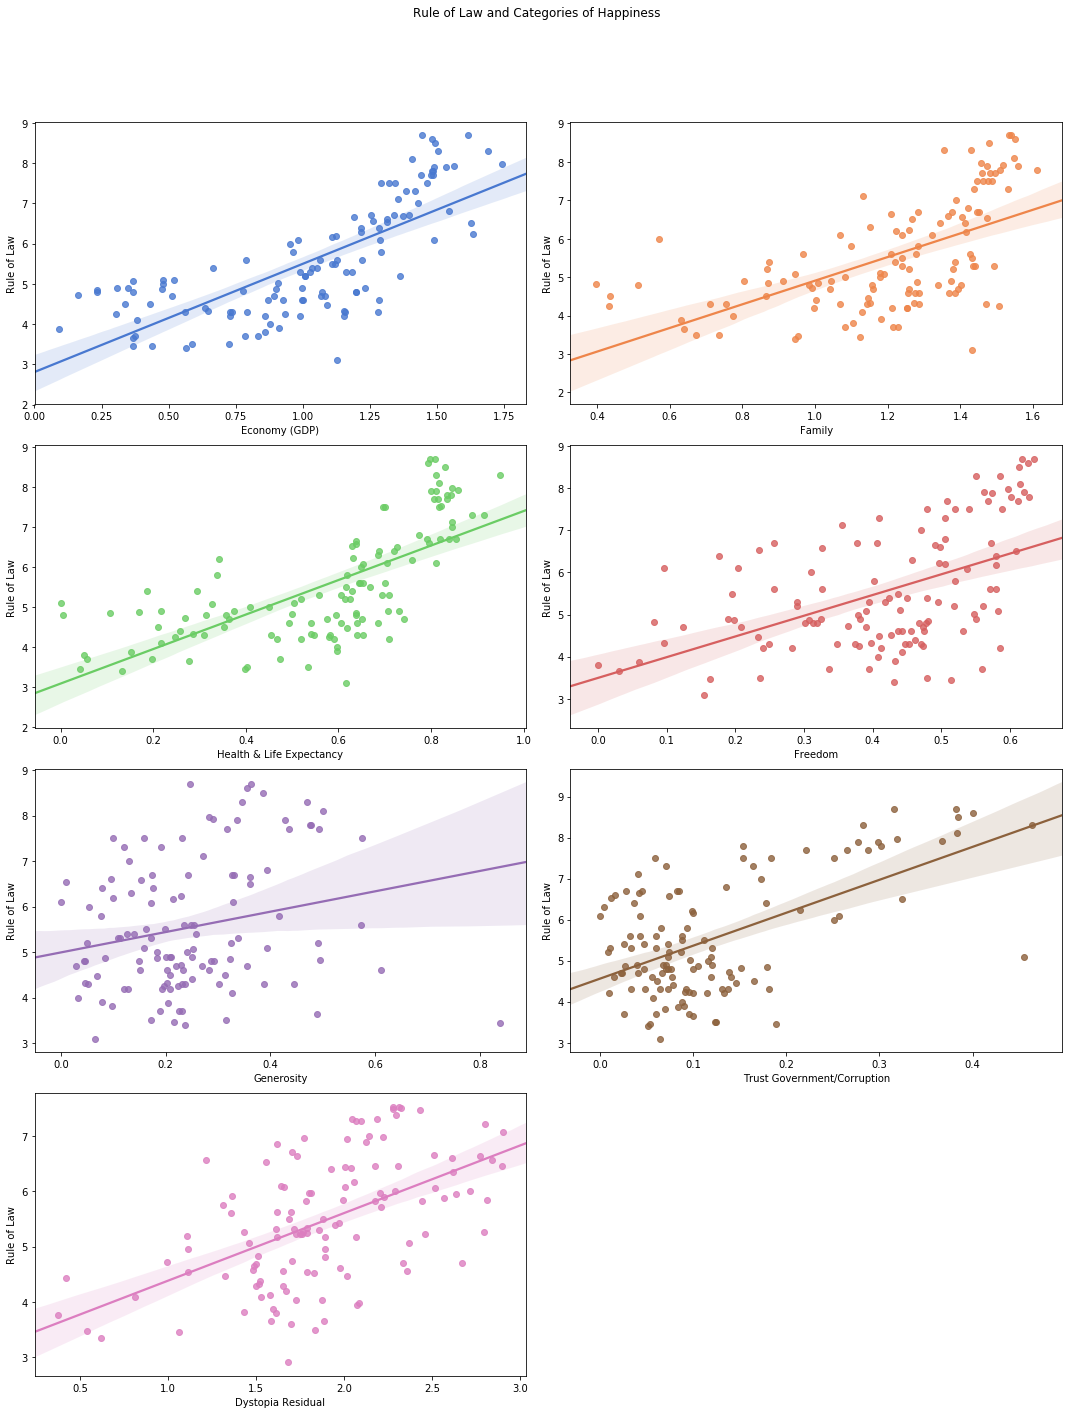

In [23]:
# plot of Rule of Law and Happiness categories
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle("Rule of Law and Categories of Happiness")

sns.regplot(x="Economy (GDP)", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[0,0])
sns.regplot(x="Family", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[0,1])

axes[0,0].set_ylabel("Rule of Law")
axes[0,0].set_xlabel("Economy (GDP)")
axes[0,1].set_ylabel("Rule of Law")
axes[0,1].set_xlabel("Family")

sns.regplot(x="Health & Life Expectancy", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[1,0])
sns.regplot(x="Freedom", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[1,1])

axes[1,0].set_ylabel("Rule of Law")
axes[1,0].set_xlabel("Health & Life Expectancy")
axes[1,1].set_ylabel("Rule of Law")
axes[1,1].set_xlabel("Freedom")

sns.regplot(x="Generosity", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[2,0])
sns.regplot(x="Trust Government/Corruption", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[2,1])

axes[2,0].set_xlabel("Generosity")
axes[2,0].set_ylabel("Rule of Law")
axes[2,1].set_xlabel("Trust Government/Corruption")
axes[2,1].set_ylabel("Rule of Law")

sns.regplot(x="Dystopia Residual", y="Happiness", data=hfi_rol_whr_happiness_subcategories, ax=axes[3,0])

axes[3,0].set_xlabel("Dystopia Residual")
axes[3,0].set_ylabel("Rule of Law")
axes[3,1].axis("off")

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = hfi_rol_whr_happiness_subcategories["Economy (GDP)"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Family"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Health & Life Expectancy"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Freedom"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Generosity"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Trust Government/Corruption"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Dystopia Residual"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)


In [24]:
# combine top level hfi with top level whr 

# retrieve movement data from Human Freedom Index grouped by country and ordered by freedom score
hfi_top_data = "SELECT countries AS Country, hf_score AS 'Freedom Score', pf_score AS 'Personal Freedom', ef_score AS 'Economic Freedom' FROM 'Human Freedom Index' GROUP BY Country ORDER BY hf_score DESC"
hfi_top_raw = pd.read_sql(hfi_top_data, con=engine)
hfi_top = hfi_top_raw.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_whr_top_combined = pd.concat([hfi_top, whr_subcategories], sort=True)
hfi_whr_top_grouped = hfi_whr_top_combined.groupby("Country")["Freedom Score", "Personal Freedom", "Economic Freedom", "Happiness", "Economy (GDP)", "Family", "Health & Life Expectancy", "Freedom", "Generosity", "Trust Government/Corruption", "Dystopia Residual"].mean()
hfi_whr_top_cleaned = hfi_whr_top_grouped.dropna()
hfi_whr_top = hfi_whr_top_cleaned.reset_index()


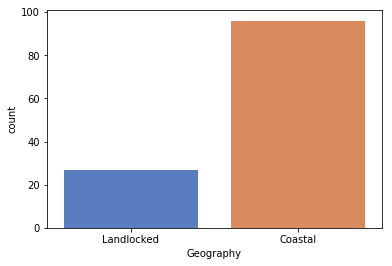

In [25]:
# create list of land-locked countries and coastal countries
landlocked_top = hfi_whr_top.loc[hfi_whr_top["Country"].isin(landlocked_countries)]
coastal_top = hfi_whr_top.loc[~hfi_whr_top["Country"].isin(landlocked_countries)]

# combine dataframes
combined_top = pd.concat([landlocked_top, coastal_top])

# mark countries as landlocked or coastal
combined_top["Geography"] = ""
combined_top["Geography"] = np.where(combined_top["Country"].isin(landlocked_countries), "Landlocked", "Coastal")
combined_top = combined_top.sort_values(by="Happiness").drop(columns=["Country"])
sns.countplot(x='Geography', data=combined_top)

combined_top['Geography'] = (combined_top['Geography']=='Landlocked').astype(int)
